In [1]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import os

%load_ext autoreload
%autoreload 2

In [2]:
directories = ['/mnt/disks/pancan/data/' + x for x in os.listdir('/mnt/disks/pancan/data/') if 'tcga_pan_can_atlas' in x]

In [3]:
def load_single_dataset(directory_path):
    rna_exp = pd.read_csv(directory_path + '/data_mrna_seq_v2_rsem.txt',
                           sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    rna_exp = rna_exp.loc[:,~rna_exp.columns.duplicated()].astype(float).copy()
    cna = pd.read_csv(directory_path + '/data_cna.txt',
                      sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    cna.drop('Cytoband', errors='ignore', inplace=True)
    cna = cna.loc[:,~cna.columns.duplicated()].astype(float).copy()
    
    genes = list(set(rna_exp.columns).intersection(cna.columns))
    indices = list(set(rna_exp.index).intersection(cna.index))
    tumor_type = pd.DataFrame(len(indices)*[directory_path.split('/')[-1].split('_')[0]],
                              index = indices, columns=['tumor'])
    return rna_exp[genes], cna[genes], tumor_type

In [4]:
rna, cna, tumor = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for path in directories:
    rna_, cna_, tumor_ = load_single_dataset(path)
    rna = pd.concat([rna_, rna])
    cna = pd.concat([cna_, cna])
    tumor = pd.concat([tumor_, tumor])
    
rna.dropna(axis=1, inplace=True)
cna.dropna(axis=1, inplace=True)
rna = (rna-rna.mean())/rna.std()

In [5]:
genetic_data = {'rna': rna, 'cna': cna}

In [6]:
absolute_TCGA = pd.read_csv('/mnt/disks/pancan/data/m1000/TCGA_mastercalls.abs_tables_JSedit.fixed.txt',
                            delimiter='\t', index_col='array')
absolute_ploidy = absolute_TCGA[['ploidy']].join(rna, how='inner')['ploidy']
absolute_ploidy.dropna(inplace=True)

In [7]:
gm = GaussianMixture(n_components=2, random_state=0).fit(absolute_ploidy.values.reshape(-1, 1))
y = gm.predict_proba(np.linspace(0,absolute_ploidy.max(),1000).reshape(-1,1))
ma = np.linspace(0,absolute_ploidy.max(),1000)[y[:,1] < 0.5].max()
absolute_ploidy_y = pd.DataFrame(index=absolute_ploidy.index, columns=['dichtomized_ploidy'],
                               data=[int(p > ma) 
                                     for p in absolute_ploidy.values])

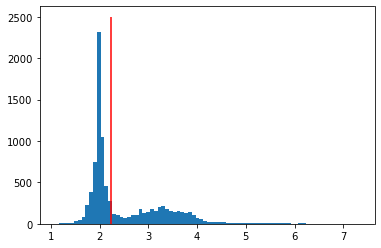

In [8]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(absolute_ploidy, bins=80)
plt.vlines([ma], color='r', ymin=0, ymax=2500)
plt.savefig('../figures/ploidy_cutoff_selection.pdf')
plt.show()

In [9]:
absolute_ploidy_y.sum()/absolute_ploidy_y.count()

dichtomized_ploidy    0.388473
dtype: float64

In [10]:
tumor_order = list(tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False).index)

In [11]:
coloring = (tumor.join(absolute_ploidy).groupby('tumor').median().sort_values('ploidy', ascending=False) > 2.5)

In [12]:
coloring['color'] = coloring['ploidy'].apply(lambda x: 'aquamarine' if x else 'whitesmoke')

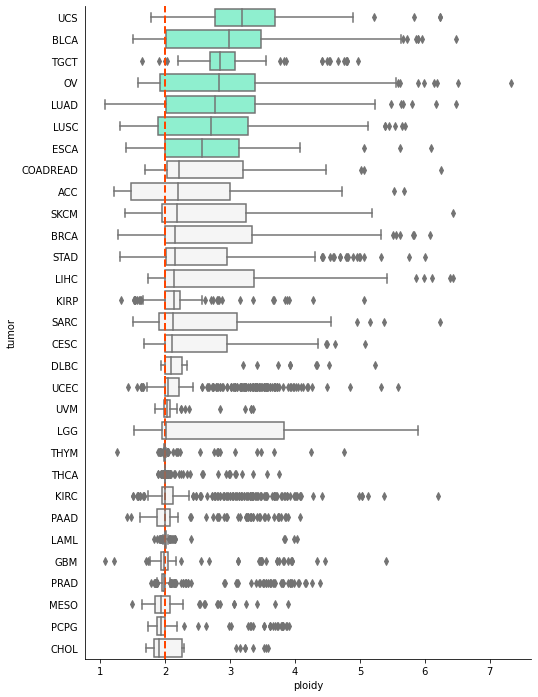

In [13]:
df = tumor.join(absolute_ploidy)
df['tumor'] = [x.upper() for x in list(df['tumor'].values)]
df['coloring'] = coloring['ploidy']
tumor_order = list(df.groupby('tumor').median().sort_values('ploidy', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(data=df, x='ploidy', y='tumor', order=tumor_order, color='w', palette=coloring['color'])
plt.axvline(2, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
plt.savefig('../figures/ploidy_by_tumortype.pdf')

## Select genes

In [14]:
pca = PCA(n_components=50)
pca.fit(rna.values)

PCA(n_components=50)

In [15]:
pca_loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=rna.columns)

In [16]:
genes_pca = abs(pca_loadings).sum(axis=1).nlargest(1000).index

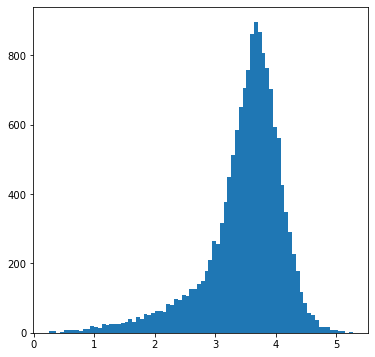

In [17]:
plt.rcParams["figure.figsize"] = (6,6)
plt.hist(abs(pca_loadings).sum(axis=1), bins=80)
plt.show()

## Run pnet

In [18]:
import Pnet

In [19]:
genetic_data = {'rna': rna[genes_pca], 'cna': cna}

In [20]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, absolute_ploidy_y)

Given 2 Input modalities
Found 9005 overlapping indicies
Initializing Train Dataset
Found 1000 overlapping genes
generated input DataFrame of size (6304, 2000)
Initializing Test Dataset
Found 1000 overlapping genes
generated input DataFrame of size (2701, 2000)


In [21]:
import ReactomeNetwork

In [22]:
reactome_network = ReactomeNetwork.ReactomeNetwork(train_dataset.get_genes())

Found 1000 overlapping genes


In [23]:
model = Pnet.PNET_NN(reactome_network=reactome_network, nbr_gene_inputs=len(genetic_data), dropout=0.2,
                      additional_dims=0, lr=1e-3, weight_decay=1)

In [24]:
train_loader, val_loader = pnet_loader.to_dataloader(train_dataset, test_dataset, 64)

In [25]:
import pytorch_lightning as pl

In [26]:
trainer = pl.Trainer(precision=32, accelerator='cuda', max_epochs=100, log_every_n_steps=50, 
                     enable_checkpointing=True)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:68: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  "Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning`"
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
di

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:209: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  "num_workers>0, persistent_workers=False, and strategy=ddp_spawn"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_bce_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [27]:
x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

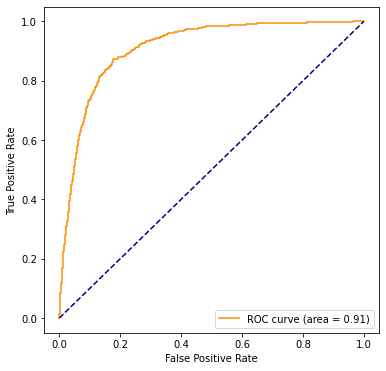

In [28]:
pred = model(x_test, additional_test)
y_pred_proba = pred.detach().numpy().squeeze()
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())
#create ROC curve
plt.plot(fpr,tpr, color="darkorange", label="ROC curve (area = %0.2f)" % test_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend(loc="lower right")
plt.savefig('PNET_ploidy_ROC_curve.pdf')
plt.show()

In [29]:
import captum

In [30]:
model

PNET_NN(
  (layers): ModuleList(
    (0): PNET_Block(
      (gene_layer): Sequential(
        (0): CustomizedLinear(input_features=1000, output_features=845, bias=True)
      )
      (pathway_layer): Sequential(
        (0): CustomizedLinear(input_features=734, output_features=845, bias=True)
      )
      (batchnorm): BatchNorm1d(845, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): PNET_Block(
      (gene_layer): Sequential(
        (0): CustomizedLinear(input_features=1000, output_features=449, bias=True)
      )
      (pathway_layer): Sequential(
        (0): CustomizedLinear(input_features=845, output_features=449, bias=True)
      )
      (batchnorm): BatchNorm1d(449, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): PNET_Block(
      (gene_layer): Sequential(
        (0): Cus

In [60]:
cond = captum.attr.LayerConductance(model, model.input_layer)
cond_vals = cond.attribute((test_dataset.x, test_dataset.additional))
cols = model.reactome_network.gene_list
cols
cond_vals_genomic = pd.DataFrame(cond_vals.detach().numpy(),
                                 columns=cols,
                                 index=test_dataset.input_df.index)
gene_imp_by_target = cond_vals_genomic.sum().T

In [64]:
gene_imp_by_target.nlargest(20)

SNAP25    210.429825
RPS27A     92.213341
RAD23B     90.980492
KDR        89.841660
MED8       88.776588
SYVN1      81.747421
POLE3      76.911896
RPS8       76.160789
EIF4B      75.775047
STAT1      74.849518
CSNK1E     74.373871
PTPN12     68.673958
CYBB       67.204514
MRPL15     66.877159
WWP1       64.011002
GNB1       63.512920
PRKACA     60.936028
PECAM1     60.527538
CDK7       58.117760
APOLD1     56.730537
dtype: float32

In [68]:
gene_importances, additional_importances = model.integrated_gradients(test_dataset)

In [75]:
abs(gene_importances.sum()).nlargest(20)

SNAP25_cna    215.138024
PMS2_cna       89.569481
KDR_cna        88.650642
MED8_cna       87.454891
RPS8_cna       84.948144
RAD23B_cna     75.627671
RPS27A_cna     75.547623
STAT1_cna      74.019554
EIF4B_cna      73.777622
PECAM1_cna     66.384225
POLE3_cna      65.484817
ZNF260         64.015713
PTPN12_cna     63.851739
APOLD1         61.352434
WWP1_cna       59.970814
RPL11          59.115179
PRKACA_cna     57.721810
SNX7_cna       57.302546
CDK7_cna       55.503872
CSNK1E_cna     55.316155
dtype: float64

In [80]:
gene_order = gene_importances.mean().sort_values(ascending=True).index
gene_order

Index(['PMS2_cna', 'RPL11', 'LDB2_cna', 'TDRKH', 'THRAP3_cna', 'ZNF395',
       'CD6_cna', 'ITGB1', 'CYCS_cna', 'SELM',
       ...
       'POLE3_cna', 'PECAM1_cna', 'EIF4B_cna', 'STAT1_cna', 'RPS27A_cna',
       'RAD23B_cna', 'RPS8_cna', 'MED8_cna', 'KDR_cna', 'SNAP25_cna'],
      dtype='object', length=2000)

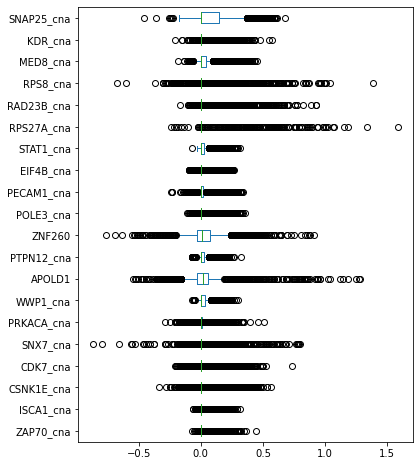

In [82]:
plt.rcParams["figure.figsize"] = (6,8)
gene_importances[list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('../figures/genes_ploidy.pdf')
plt.show()

In [83]:
pathway_importances = model.layerwise_importance(test_dataset)

In [84]:
for l in pathway_importances:
    print(l.nlargest(5))

VEGF ligand-receptor interactions          156.181595
Mitochondrial translation elongation       139.383224
mRNA Splicing - Major Pathway              127.062675
Estrogen-dependent gene expression         122.678314
Apoptotic cleavage of cellular proteins    122.579018
dtype: float32
Intraflagellar transport                                                        217.495132
Degradation of beta-catenin by the destruction complex                          193.389877
Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC)    181.517853
Mitochondrial translation                                                       164.518677
RNA polymerase II transcribes snRNA genes                                       161.541641
dtype: float32
Apoptosis                                          773.331299
Processing of Capped Intron-Containing Pre-mRNA    153.883087
Metabolism of amino acids and derivatives          151.802902
Cell surface interactions at the vascular wall     147.2279

In [87]:
absolute_ploidy

TCGA-OR-A5J1-01    2.00
TCGA-OR-A5J2-01    1.30
TCGA-OR-A5J3-01    1.27
TCGA-OR-A5J5-01    2.79
TCGA-OR-A5J6-01    3.34
                   ... 
TCGA-HT-7608-01    1.95
TCGA-HT-A61B-01    3.69
TCGA-J7-6720-01    2.14
TCGA-LL-A442-01    1.99
TCGA-RD-A7BW-01    1.88
Name: ploidy, Length: 9092, dtype: float64

In [97]:
list(gene_order)[::-1][:5]

['SNAP25_cna', 'KDR_cna', 'MED8_cna', 'RPS8_cna', 'RAD23B_cna']

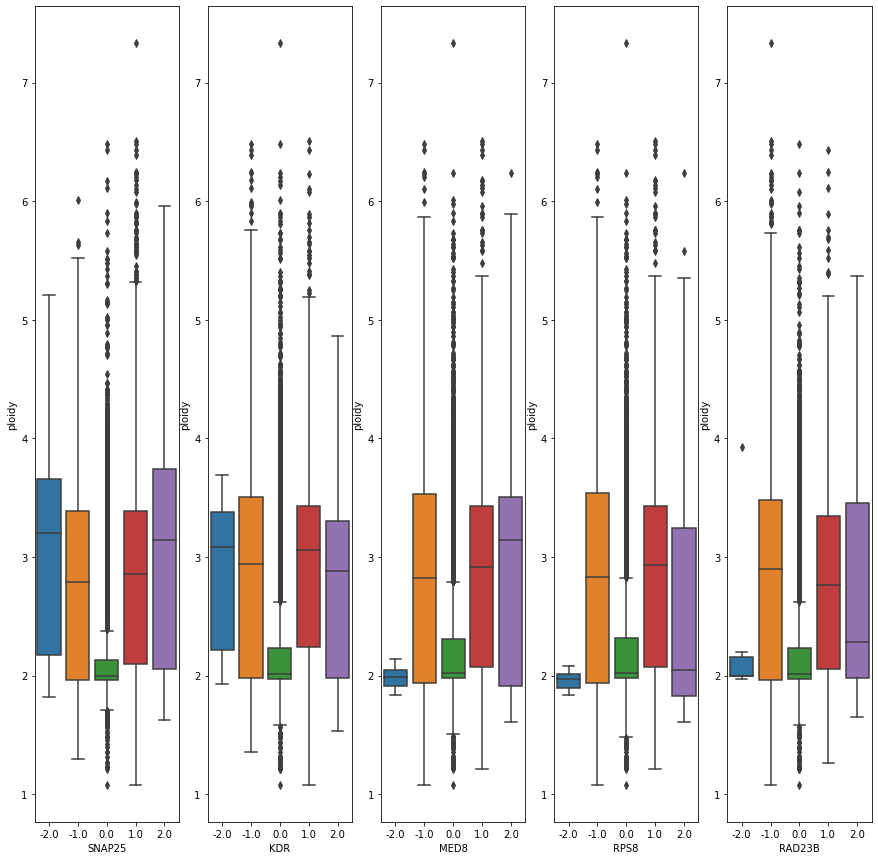

In [104]:
fig, axs = plt.subplots(1, 5, figsize=((15, 15)))
for i, gene in enumerate(list(gene_order)[::-1][:5]):
    gene = gene.split('_')[0]
    sns.boxplot(data=cna.join(absolute_ploidy), x=gene, y='ploidy', ax=axs[i])
plt.show()

In [ ]:
pred = model(torch.tensor(x_test, dtype=torch.float),
                          torch.tensor(additional_test, dtype=torch.float)
            )

In [ ]:
pred_ = pd.DataFrame(pred.detach().numpy(), index=test_dataset.input_df.index, columns=['prediction'])

In [ ]:
pred_.join(tumor)

In [ ]:
df = pred_.join(tumor)
df['tumor'] = [x.upper() for x in list(df['tumor'].values)]
tumor_order = list(df.groupby('tumor').median().sort_values('prediction', ascending=False).index)
plt.rcParams["figure.figsize"] = (8,12)
sns.boxplot(df, x='prediction', y='tumor', order=tumor_order, color='w')
plt.axvline(0.5, color='orangered', linestyle='--', linewidth=2)
plt.tick_params(axis='y', which='both',  left=False, top=False, labelleft=True)
sns.despine()
#plt.savefig('ploidy_by_tumortype.pdf')

In [ ]:
missclass_df = pred_.join(tumor).join(test_dataset.target)
missclass_df['misclass'] = missclass_df.apply(lambda x: 1-int(round(x['prediction'])==x['dichtomized_ploidy']), axis=1)
sns.scatterplot(missclass_df.groupby('tumor').mean(), x='dichtomized_ploidy', y='misclass')

## Multiple runs

In [ ]:
def fold_run(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=True)

        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        pred = model(torch.tensor(x_test, dtype=torch.float),
                                  torch.tensor(additional_test, dtype=torch.float)
                    )
        y_pred_proba = pred.detach().numpy().squeeze()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())

        aucs.append(test_auc)

        gene_importances, additional_importances = model.deepLIFT(test_dataset)
        most_imp_genes.append(gene_importances.sum())
    return aucs, most_imp_genes

In [ ]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.astype(float).values
        additional_train = train_dataset.additional_data.astype(float).values
        y_train = train_dataset.target.astype(float).values.reshape(-1)
        x_test = test_dataset.input_df.astype(float).values
        additional_test = test_dataset.additional_data.astype(float).values
        y_test = test_dataset.target.astype(float).values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns))
    return aucs, most_imp_genes

In [ ]:
ploidy_absolut_auc, ploidy_absolut_genes = fold_run(genetic_data, absolute_ploidy_y, 10)
ploidy_absolut_auc_rf, ploidy_absolut_genes_rf = fold_run_rf(genetic_data, absolute_ploidy_y, 10)

In [ ]:
data_pnet = [ploidy_absolut_auc]
data_rf = [ploidy_absolut_auc_rf]

ticks = ['ploidy \n by absolut']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
    
bpl = plt.boxplot(data_pnet, positions=np.array(range(len(data_pnet)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_rf, positions=np.array(range(len(data_pnet)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='pnet')
plt.plot([], c='#2C7BB6', label='rf')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('absolute_ploidy_auc_pnet_vs_rf.pdf')

In [ ]:
ploidy_absolut_genes

In [ ]:
ploidy_absolut_genes_rf

In [ ]:
gene_order = pd.DataFrame(ploidy_absolut_genes).mean().sort_values(ascending=False).index
df_sum = pd.DataFrame(ploidy_absolut_genes)

In [ ]:
gene_order_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf]).mean().sort_values(ascending=False).index
df_sum_rf = pd.DataFrame([x[0] for x in ploidy_absolut_genes_rf])

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
df_sum[list(gene_order[:20]) + list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('Ploidy_important_genes.pdf')
plt.show()

In [ ]:
def check_annotate(x, y):
    if y > 1e-3/(x)**1.9 + 1e-3:
        return True
    else:
        return False

In [ ]:
import scipy.stats as ss

In [ ]:
comb_df['pnet_rank'] = ss.rankdata(comb_df['pnet_imp'])
comb_df['rf_rank'] = ss.rankdata(comb_df['rf_imp'])

In [ ]:
comb_df = pd.DataFrame([df_sum.mean(), df_sum_rf.mean()]).T
comb_df.columns = ['pnet_imp', 'rf_imp']
comb_df['pnet_rank'] = len(comb_df['pnet_imp']) - ss.rankdata(abs(comb_df['pnet_imp']))
comb_df['rf_rank'] = len(comb_df['rf_imp']) - ss.rankdata(abs(comb_df['rf_imp']))
comb_df['annotate'] = comb_df.apply(lambda x: x['pnet_rank'] + x['rf_rank'] < 100, axis=1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(comb_df['pnet_imp'], comb_df['rf_imp'], s=10)

for i in range(len(comb_df)):
    if comb_df.iloc[i]['annotate']:
        ax.annotate(comb_df.iloc[i].name, (comb_df.iloc[i]['pnet_imp'], comb_df.iloc[i]['rf_imp']))

plt.ylabel('rf importance')
plt.xlabel('pnet importance')
plt.title('Ploidy classification gene importance')
plt.savefig('important_genes_ploidy_scatter.pdf')
plt.show()

In [ ]:
import gseapy as gp

In [ ]:
def prerank_gsea(gene_importances, gene_list):
    gene_sets='../data/reactome/ReactomePathways.gmt'
    gene_importance_scores = pd.DataFrame(index=gene_list)
    gene_importance_scores['1'] = gene_importances.values.reshape((2,-1)).sum(axis=0)
        
    pre_res = gp.prerank(rnk=gene_importance_scores,
                         gene_sets = gene_sets,
                         threads=8,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000,
                         outdir='../prerank_gsea',
                         seed=6,
                         verbose=True
                        )
    return pre_res

In [ ]:
pre_res_rf = prerank_gsea(comb_df['rf_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_rf = list(pre_res_rf.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_rf

In [ ]:
pre_res_pnet = prerank_gsea(comb_df['pnet_imp'], list(comb_df.iloc[:int(comb_df.shape[0]/2)].index))

In [ ]:
top_hits_pnet = list(pre_res_pnet.res2d.sort_values('NOM p-val').head(15)['Term'])

In [ ]:
top_hits_pnet